In [1]:
import numpy as np
import dxchange
import holotomo
import matplotlib.pyplot as plt
import cv2
import xraylib
import random
import scipy.ndimage as ndimage
import tifffile

PLANCK_CONSTANT = 4.135667696e-18  # [keV*s]
SPEED_OF_LIGHT = 299792458  # [m/s]

%matplotlib inline

# Init data sizes and parametes of the PXM of ID16A

In [2]:
n0 = 2**11
ndist = 4
psiill = np.ones([ndist,n0,n0],dtype='complex64')
psiill00 = psiill.copy()
for k in range(ndist):
    psiill[k] = (tifffile.imread(f'data/modeling/codes_siemens_{n0}_{k}_amp.tiff')*np.exp(1j* tifffile.imread(f'data/modeling/codes_siemens_{n0}_{k}_angle.tiff')))
data = np.zeros([ndist,1,n0,n0],dtype='float32')
for k in range(ndist):
    data[k] = dxchange.read_tiff(f'data/modeling/data_siemens_{n0}_{k}.tiff')

psiill00=psiill.copy()

In [3]:
n = 1024  # object size in x,y
nz = 1024  # object size in z    

# binning
for k in range(int(np.log2(n0//n))):
    data=(data[:,:,::2]+data[:,:,1::2])/2
for k in range(int(np.log2(n0//n))):
    data=(data[:,:,:,::2]+data[:,:,:,1::2])/2

voxelsize = 10e-9*2048/n # [m] object voxel size 
energy = 33.35  # [keV] x-ray energy    
wavelength = PLANCK_CONSTANT * SPEED_OF_LIGHT / energy # [m]
focusToDetectorDistance = 1.28 # [m]
sx0 = 3.7e-4 # [m] motor offset from the focal spot

z1 = np.array([4.584,4.765,5.488,6.9895])*1e-3-sx0 # distances between planes and the focal spot
z2 = focusToDetectorDistance-z1 # propagation distance between the code and detector

magnifications = (z1+z2)/z1 # magnification when propagating from the sample to the code
norm_magnifications = magnifications/magnifications[0] # normalized magnifications
distances = (z1*z2)/(z1+z2) # propagation distances after switching from the point source wave to plane wave,
distances = distances*norm_magnifications**2 # scaled propagation distances due to magnified probes


## Read data

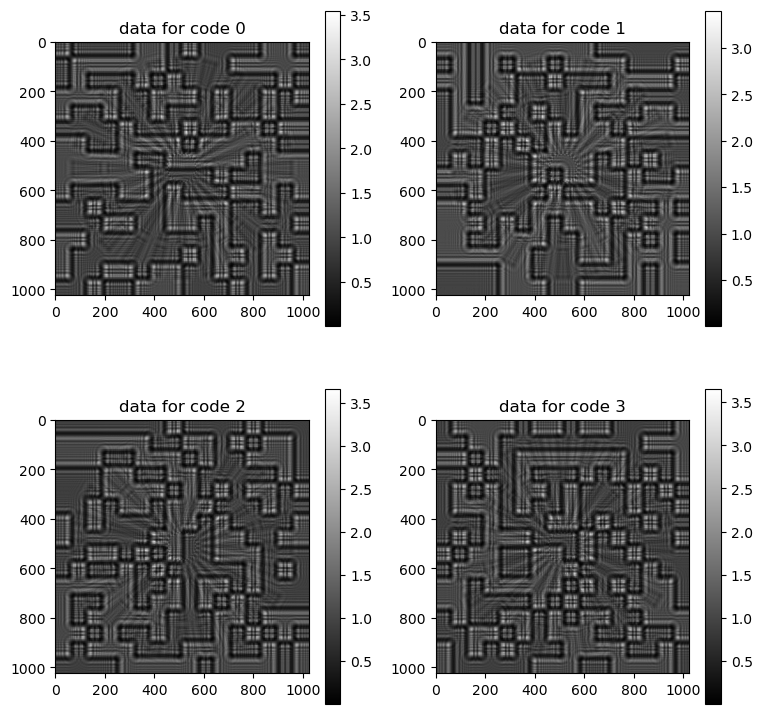

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(data[0,0],cmap='gray')
axs[0,0].set_title('data for code 0')
fig.colorbar(im)
im=axs[0,1].imshow(data[1,0],cmap='gray')
axs[0,1].set_title('data for code 1')
fig.colorbar(im)
im=axs[1,0].imshow(data[2,0],cmap='gray')
axs[1,0].set_title('data for code 2')
fig.colorbar(im)
im=axs[1,1].imshow(data[-1,0],cmap='gray')
axs[1,1].set_title('data for code 3')
fig.colorbar(im)

## Read the probe

In [5]:
prb = np.ones([ndist,nz,n],dtype='complex64')
# prb[:] = (tifffile.imread(f'data/prb_id16a/prb_abs_{n}.tiff')*np.exp(1j* tifffile.imread(f'data/prb_id16a/prb_phase_{n}.tiff')))[0]

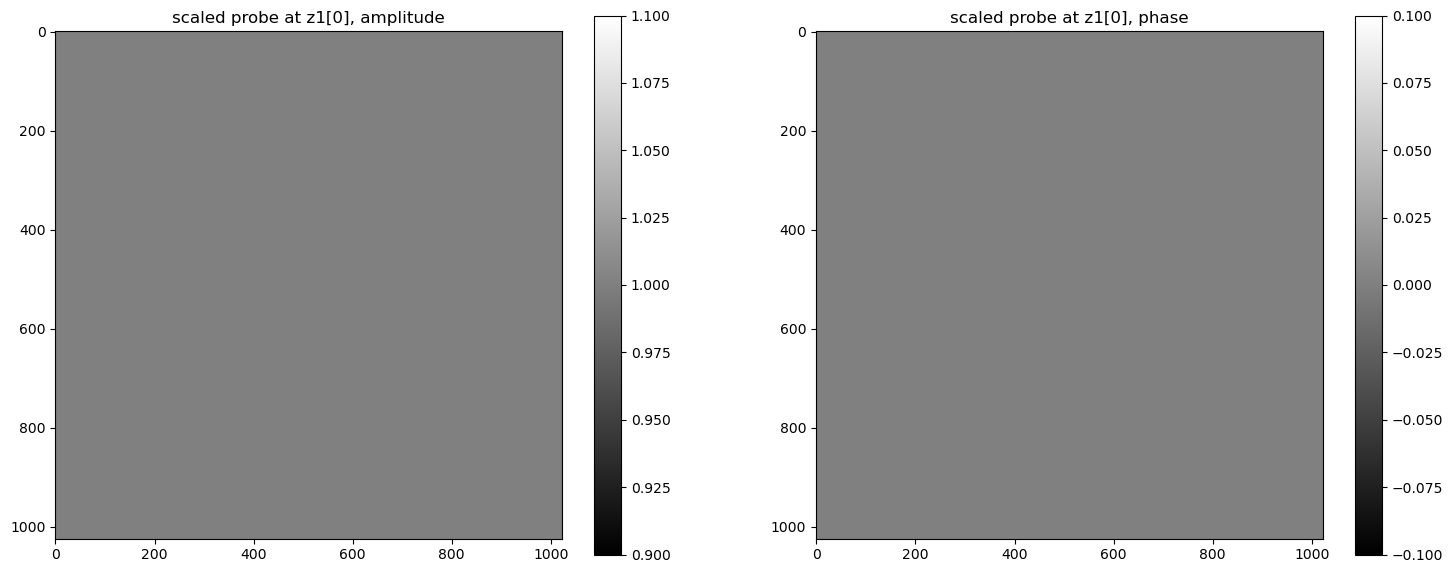

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(18, 7))
im=axs[0].imshow(np.abs(prb[0]),cmap='gray')
axs[0].set_title('scaled probe at z1[0], amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(prb[0]),cmap='gray')
axs[1].set_title('scaled probe at z1[0], phase')
fig.colorbar(im)

## Create a solver class for holography

In [7]:
pslv = holotomo.SolverHolo(1, nz, n, 1, voxelsize, energy, distances, norm_magnifications) 

## Conjugate gradient solver

In [8]:

import cupy as cp
import numpy as np
import holotomo

def line_search(minf, gamma, u, fu, d, fd):
    """ Line search for the step sizes gamma"""
    while(minf(u, fu)-minf(u+gamma*d, fu+gamma*fd) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if(gamma <= 1e-12):  # direction not found
        #print('no direction')
        gamma = 0
    return gamma
    
def cg_holo(pslv, data, init, prb,  piter, codes=None):
    """Conjugate gradients method for holography"""

    # minimization functional
    def minf(psi,fpsi):
        f = cp.linalg.norm(cp.abs(fpsi)-cp.sqrt(data))**2            
        # f = cp.linalg.norm(cp.abs(fpsi)**2-data)**2            
        return f        
    psi = init.copy()
    norm_data = np.linalg.norm(data)
    maxprb = cp.max(cp.abs(prb))
    for i in range(piter):
        fpsi = pslv.fwd_holo(psi,prb,codes)
        grad = pslv.adj_holo(
           fpsi-cp.sqrt(data)*cp.exp(1j*cp.angle(fpsi)), prb, codes)/maxprb**2
        #grad = pslv.adj_holo(
             #(cp.abs(fpsi)**2-data)*fpsi,prb)/maxprb**2
        
        # Dai-Yuan direction
        if i == 0:
            d = -grad
        else:
            d = -grad+cp.linalg.norm(grad)**2 / \
                ((cp.sum(cp.conj(d)*(grad-grad0))))*d
        grad0 = grad
        # line search
        fd = pslv.fwd_holo(d, prb,codes)
        gamma = line_search(minf, 1, psi, fpsi, d, fd)
        psi = psi + gamma*d
        err=minf(psi,fpsi)
        if i%8==0:
            print(f'{i}) {gamma=}, {err=:1.2e}')    
        
            
    
    return psi

def cg_holo_batch(pslv, data, init, prb, piter, codes=None):
    """Batch of CG solvers"""
    
    res = np.zeros([pslv.ntheta, pslv.nz, pslv.n], dtype='complex64')
    prb_gpu = cp.array(prb)            
    if codes is not None:
        codes_gpu = cp.array(codes)
    else:
        codes_gpu=None          
    for ids in holotomo.utils.chunk(range(pslv.ntheta), pslv.ptheta):
        # copy data part to gpu
        data_gpu = cp.array(data[:,ids])
        init_gpu = cp.array(init[ids])
        
        # Radon transform
        res_gpu = cg_holo(pslv, data_gpu, init_gpu,prb_gpu, piter, codes_gpu)
        # copy result to cpu
        res[ids] = res_gpu.get()
    return res


piter = 512 # number of CG iters
init = np.ones([1,nz,n],dtype='complex64')  # initial guess
rec = cg_holo_batch(pslv, data, init, prb,  piter)



0) gamma=0.5, err=2.20e+05
8) gamma=0.25, err=1.39e+05
16) gamma=0.25, err=1.35e+05
24) gamma=0.25, err=1.29e+05
32) gamma=0.25, err=1.21e+05
40) gamma=0.5, err=1.16e+05
48) gamma=0.25, err=1.12e+05
56) gamma=0.5, err=1.08e+05
64) gamma=0.25, err=1.05e+05
72) gamma=0.5, err=1.03e+05
80) gamma=0.25, err=1.00e+05
88) gamma=0.25, err=9.81e+04
96) gamma=0.5, err=9.63e+04
104) gamma=0.25, err=9.49e+04
112) gamma=0.25, err=9.32e+04
120) gamma=0.5, err=9.19e+04
128) gamma=0.25, err=9.08e+04
136) gamma=0.25, err=8.98e+04
144) gamma=0.5, err=8.88e+04
152) gamma=0.25, err=8.80e+04
160) gamma=0.25, err=8.73e+04
168) gamma=0.25, err=8.66e+04
176) gamma=0.25, err=8.61e+04
184) gamma=0.5, err=8.55e+04
192) gamma=0.25, err=8.50e+04
200) gamma=0.25, err=8.45e+04
208) gamma=0.25, err=8.40e+04
216) gamma=0.25, err=8.35e+04
224) gamma=0.5, err=8.31e+04
232) gamma=0.25, err=8.28e+04
240) gamma=0.5, err=8.24e+04
248) gamma=0.5, err=8.20e+04
256) gamma=0.25, err=8.17e+04
264) gamma=0.25, err=8.14e+04
272) g

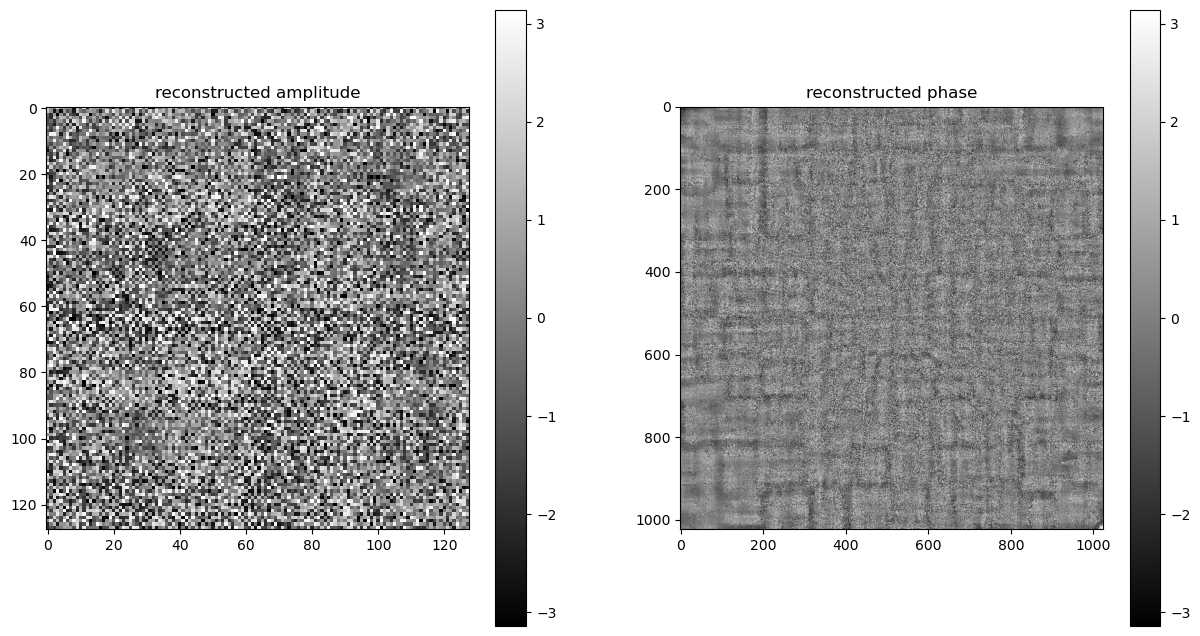

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
im=axs[0].imshow(np.angle(rec[0,n//2-n//16:n//2+n//16,n//2-n//16:n//2+n//16]),cmap='gray')
axs[0].set_title('reconstructed amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(rec[0]),cmap='gray')
axs[1].set_title('reconstructed phase')
fig.colorbar(im)